In [56]:
import torch, pandas as pd, matplotlib.pyplot as plt, numpy as np, random, timeit
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [80]:
# Constantes para configuração do modelo e do treinamento

# Semente aleatória para reprodutibilidade
RANDON_SEED = 42

# Tamanho do lote (batch) para o treinamento
BATCH_SIZE = 512

# Número de épocas de treinamento
EPOCHS = 10

# Taxa de aprendizagem (learning rate) para o otimizador
LEARNING_RATE = 1e-4

# Número de classes no conjunto de dados (no caso do MNIST, 10 dígitos)
NUM_CLASSES = 10

# Tamanho do patch para a extração de características das imagens
PATCH_SIZE = 4

# Tamanho da imagem (28x28 para o MNIST)
IMG_SIZE = 28

# Número de canais de entrada (1 para imagens em escala de cinza)
IN_CHANNELS = 1

# Número de cabeças de atenção no mecanismo de atenção multi-cabeça
NUM_HEADS = 8

# Taxa de dropout para regularização
DROPOUT = 1e-3

# Dimensão oculta para camadas lineares no codificador
HIDDEN_DIM = 768

# Peso de decaimento para o otimizador Adam
ADAM_WEIGHT_DECAY = 0

# Betas para o otimizador Adam
ADAM_BETAS = (0.9, 0.999)

# Função de ativação para o codificador
ACTIVATION_FN = "gelu"

# Número de camadas de codificador na arquitetura Transformer
NUM_ENCODERS = 4

# Dimensão de embedding (calculada com base no tamanho do patch e nos canais de entrada)
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS  # (4^2) * 1 = 16

# Número total de patches em uma imagem (calculado com base no tamanho da imagem e do patch)
NUM_PATCHS = (IMG_SIZE // PATCH_SIZE) ** 2  # 49

# Configuração da semente aleatória para garantir reprodutibilidade
random.seed(RANDON_SEED)
np.random.seed(RANDON_SEED)
torch.manual_seed(RANDON_SEED)
torch.cuda.manual_seed(RANDON_SEED)
torch.cuda.manual_seed_all(RANDON_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dispositivo de execução (GPU se disponível, caso contrário, CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
# Classe para Embutir os Patches das Imagens


class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        # Definindo a estrutura para extrair os patches
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2),
        )

        # Token de classificação
        self.cls_token = nn.Parameter(
            torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True
        )

        # Embeddings de posição
        self.position_embeddings = nn.Parameter(
            torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True
        )

        # Dropout
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Expandindo o token de classificação para o batch
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        # Passe adiante para extrair os patches e rearranjá-los
        x = self.patcher(x).permute(0, 2, 1)

        # Concatenando o token de classificação com os patches
        x = torch.cat([cls_token, x], dim=1)

        # Adicionando os embeddings de posição
        x = self.position_embeddings + x

        # Aplicando dropout
        x = self.dropout(x)

        return x

In [59]:
# Testando codagem feita
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHS, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)

torch.Size([512, 50, 16])


In [60]:
# Classe para Vision Transformer (ViT)
class ViT(nn.Module):
    def __init__(
        self,
        num_patches,
        img_size,
        num_classes,
        patch_size,
        embed_dim,
        num_encoders,
        num_heads,
        hidden_dim,
        dropout,
        activation,
        in_channels,
    ):
        super().__init__()

        # Bloco de embeddings
        self.embeddings_block = PatchEmbedding(
            embed_dim, patch_size, num_patches, dropout, in_channels
        )

        # Camadas de codificador
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True,
        )

        # Bloco de codificador
        self.encoder_blocks = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoders
        )

        # Cabeça MLP
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )

    def forward(self, x):
        # Passar pelas camadas de embedding
        x = self.embeddings_block(x)

        # Passar pelos blocos de codificador
        x = self.encoder_blocks(x)

        # Aplicar a cabeça MLP apenas no token CLS
        x = self.mlp_head(x[:, 0, :])

        return x

In [61]:
model = ViT(
    NUM_PATCHS, 
    IMG_SIZE, 
    NUM_CLASSES, 
    PATCH_SIZE, 
    EMBED_DIM,
    NUM_ENCODERS,
    NUM_HEADS,
    HIDDEN_DIM,
    DROPOUT,
    ACTIVATION_FN,
    IN_CHANNELS
    ).to(device)
x = torch.rand(512, 1, 28, 28)
print(model(x).shape)

/home/gus/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:292: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


In [62]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [63]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDON_SEED, shuffle=True)

In [66]:
# Conjunto de Dados de Treinamento para MNIST
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        super().__init__()

        # Inicialização dos dados
        self.images = images
        self.labels = labels
        self.indices = indices

        # Transformações das imagens
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),  # Converter para imagem PIL
                transforms.RandomRotation(15),  # Rotação aleatória de até 15 graus
                transforms.ToTensor(),  # Converter para tensor
                transforms.Normalize([0.5], [0.5]),  # Normalizar os pixels
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        # Obter a imagem, rótulo e índice para o índice fornecido
        image = (
            self.images[index].reshape((28, 28)).astype(np.uint8)
        )  # Reshape e converter para uint8
        label = self.labels[index]  # Obter o rótulo
        index = self.indices[index]  # Obter o índice
        image = self.transform(image)  # Aplicar transformações à imagem

        # Retornar um dicionário contendo a imagem, rótulo e índice
        return {
            "image": image,  # Imagem transformada
            "label": label,  # Rótulo
            "index": index,  # Índice
        }

In [67]:
# Conjunto de Dados de Validação para MNIST
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        super().__init__()

        # Inicialização dos dados
        self.images = images
        self.labels = labels
        self.indices = indices

        # Transformações das imagens
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),  # Converter para tensor
                transforms.Normalize([0.5], [0.5]),  # Normalizar os pixels
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        # Obter a imagem, rótulo e índice para o índice fornecido
        image = (
            self.images[index].reshape((28, 28)).astype(np.uint8)
        )  # Reshape e converter para uint8
        label = self.labels[index]  # Obter o rótulo
        index = self.indices[index]  # Obter o índice
        image = self.transform(image)  # Aplicar transformações à imagem

        # Retornar um dicionário contendo a imagem, rótulo e índice
        return {"image": image, "label": label, "index": index}

In [68]:
# Conjunto de Dados de Submissão para MNIST
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indices) -> None:
        super().__init__()

        # Inicialização dos dados
        self.images = images
        self.indices = indices

        # Transformações das imagens
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),  # Converter para tensor
                transforms.Normalize([0.5], [0.5]),  # Normalizar os pixels
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> any:
        # Obter a imagem e o índice para o índice fornecido
        image = (
            self.images[index].reshape((28, 28)).astype(np.uint8)
        )  # Reshape e converter para uint8
        index = self.indices[index]  # Obter o índice
        image = self.transform(image)  # Aplicar transformações à imagem

        # Retornar um dicionário contendo a imagem e o índice
        return {"image": image, "index": index}

In [69]:
# Criando os conjuntos de dados de treinamento, validação e teste para MNIST

# Conjunto de dados de treinamento
train_dataset = MNISTTrainDataset(
    train_df.iloc[:, 1:].values.astype(
        np.uint8
    ),  # Imagens de treinamento convertidas para uint8
    train_df.iloc[:, 0].values,  # Rótulos de treinamento
    train_df.index.values,  # Índices dos dados de treinamento
)

# Conjunto de dados de validação
val_dataset = MNISTValDataset(
    val_df.iloc[:, 1:].values.astype(
        np.uint8
    ),  # Imagens de validação convertidas para uint8
    val_df.iloc[:, 0].values,  # Rótulos de validação
    val_df.index.values,  # Índices dos dados de validação
)

# Conjunto de dados de teste/submissão
test_dataset = MNISTSubmitDataset(
    test_df.values.astype(
        np.uint8
    ),  # Imagens de teste/submissão convertidas para uint8
    test_df.index.values,  # Índices dos dados de teste/submissão
)

<Figure size 640x480 with 0 Axes>

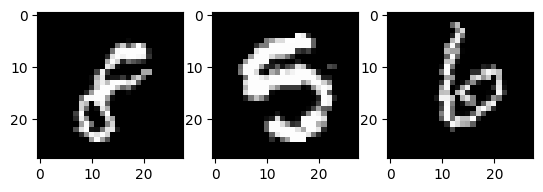

In [70]:
plt.figure()
f, axarr = plt.subplots(1, 3)
for i in range(3):
    axarr[i].imshow(train_dataset[i]["image"].squeeze(), cmap="gray")

In [71]:
# Criando os dataloaders para os conjuntos de dados de treinamento, validação e teste

# Dataloader para o conjunto de dados de treinamento
train_dataloader = DataLoader(
    dataset=train_dataset,  # Conjunto de dados de treinamento
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=True,  # Embaralhar os dados durante o treinamento
)

# Dataloader para o conjunto de dados de validação
val_dataloader = DataLoader(
    dataset=val_dataset,  # Conjunto de dados de validação
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=True,  # Embaralhar os dados durante a validação (pode não ser necessário, dependendo do contexto)
)

# Dataloader para o conjunto de dados de teste/submissão
test_dataloader = DataLoader(
    dataset=test_dataset,  # Conjunto de dados de teste/submissão
    batch_size=BATCH_SIZE,  # Tamanho do lote (batch)
    shuffle=False,  # Não há necessidade de embaralhar os dados durante o teste/submissão
)

In [72]:
# Definição da função de perda (loss) e do otimizador para o modelo

# Função de perda (loss)
criterion = nn.CrossEntropyLoss()

# Otimizador Adam
optimizer = optim.Adam(
    model.parameters(),  # Parâmetros do modelo a serem otimizados
    betas=ADAM_BETAS,  # Fatores de decaimento de momento (Adam betas)
    lr=LEARNING_RATE,  # Taxa de aprendizagem (learning rate)
    weight_decay=ADAM_WEIGHT_DECAY,  # Penalização de L2 (weight decay) para regularização
)

In [81]:
# Treinamento do modelo com laço de épocas

# Inicialização do tempo de execução
start = timeit.default_timer()

# Laço de épocas
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    # Modo de treinamento
    model.train()
    train_labels, train_preds, train_running_loss = [], [], 0

    # Laço de treinamento
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = (
            img_label["image"].float().to(device)
        )  # Obter as imagens e enviá-las para o dispositivo
        label = (
            img_label["label"].type(torch.uint8).to(device)
        )  # Obter os rótulos e enviá-los para o dispositivo

        y_pred = model(img)  # Fazer a previsão
        y_pred_label = torch.argmax(y_pred, dim=1)  # Obter as previsões

        train_labels.extend(label.cpu().detach())  # Adicionar os rótulos verdadeiros
        train_preds.extend(y_pred_label.cpu().detach())  # Adicionar as previsões

        loss = criterion(y_pred, label)  # Calcular a perda

        optimizer.zero_grad()  # Zerar os gradientes
        loss.backward()  # Retropropagação
        optimizer.step()  # Atualizar os pesos

        train_running_loss += loss.item()  # Somar a perda

    train_loss = train_running_loss / (idx + 1)  # Calcular a média da perda

    # Modo de avaliação
    model.eval()
    val_labels, val_preds, val_running_loss = [], [], 0

    # Avaliação no conjunto de validação
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = (
                img_label["image"].float().to(device)
            )  # Obter as imagens e enviá-las para o dispositivo
            label = (
                img_label["label"].type(torch.uint8).to(device)
            )  # Obter os rótulos e enviá-los para o dispositivo

            y_pred = model(img)  # Fazer a previsão
            y_pred_label = torch.argmax(y_pred, dim=1)  # Obter as previsões

            val_labels.extend(label.cpu().detach())  # Adicionar os rótulos verdadeiros
            val_preds.extend(y_pred_label.cpu().detach())  # Adicionar as previsões

            loss = criterion(y_pred, label)  # Calcular a perda
            val_running_loss += loss.item()  # Somar a perda

    val_loss = val_running_loss / (idx + 1)  # Calcular a média da perda

    # Imprimir as métricas de treinamento e validação
    print("-" * 30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(
        f"Train accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}"
    )
    print(
        f"Validation accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}"
    )

# Fim do tempo de execução
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")  # Imprimir o tempo total de treinamento

 10%|█         | 1/10 [03:06<27:57, 186.40s/it]

------------------------------
Train Loss EPOCH 1: 1.2615
Validation Loss EPOCH 1: 1.1041
Train accuracy EPOCH 1: 0.6395
Validation accuracy EPOCH 1: 0.7045


 20%|██        | 2/10 [06:14<24:59, 187.47s/it]

------------------------------
Train Loss EPOCH 2: 1.1604
Validation Loss EPOCH 2: 1.0330
Train accuracy EPOCH 2: 0.6738
Validation accuracy EPOCH 2: 0.7160


 30%|███       | 3/10 [09:21<21:51, 187.37s/it]

------------------------------
Train Loss EPOCH 3: 1.0839
Validation Loss EPOCH 3: 0.9592
Train accuracy EPOCH 3: 0.7000
Validation accuracy EPOCH 3: 0.7517


 40%|████      | 4/10 [12:29<18:45, 187.54s/it]

------------------------------
Train Loss EPOCH 4: 1.0136
Validation Loss EPOCH 4: 0.8933
Train accuracy EPOCH 4: 0.7209
Validation accuracy EPOCH 4: 0.7681


 50%|█████     | 5/10 [15:39<15:41, 188.36s/it]

------------------------------
Train Loss EPOCH 5: 0.9540
Validation Loss EPOCH 5: 0.8375
Train accuracy EPOCH 5: 0.7407
Validation accuracy EPOCH 5: 0.7900


 60%|██████    | 6/10 [18:48<12:34, 188.75s/it]

------------------------------
Train Loss EPOCH 6: 0.9128
Validation Loss EPOCH 6: 0.7661
Train accuracy EPOCH 6: 0.7502
Validation accuracy EPOCH 6: 0.8083


 70%|███████   | 7/10 [21:59<09:28, 189.37s/it]

------------------------------
Train Loss EPOCH 7: 0.8605
Validation Loss EPOCH 7: 0.7295
Train accuracy EPOCH 7: 0.7678
Validation accuracy EPOCH 7: 0.8295


 80%|████████  | 8/10 [25:09<06:18, 189.47s/it]

------------------------------
Train Loss EPOCH 8: 0.8223
Validation Loss EPOCH 8: 0.7094
Train accuracy EPOCH 8: 0.7765
Validation accuracy EPOCH 8: 0.8202


 90%|█████████ | 9/10 [28:18<03:09, 189.53s/it]

------------------------------
Train Loss EPOCH 9: 0.7801
Validation Loss EPOCH 9: 0.6639
Train accuracy EPOCH 9: 0.7894
Validation accuracy EPOCH 9: 0.8374


100%|██████████| 10/10 [31:28<00:00, 188.87s/it]

------------------------------
Train Loss EPOCH 10: 0.7238
Validation Loss EPOCH 10: 0.6068
Train accuracy EPOCH 10: 0.8096
Validation accuracy EPOCH 10: 0.8626
Training Time: 1888.72s


In [82]:
# Previsão do modelo nos dados de teste/submissão

# Listas para armazenar rótulos, IDs e imagens
labels, ids, imgs = [], [], []

# Modo de avaliação
model.eval()

# Avaliação sem cálculo de gradientes
with torch.no_grad():
    # Iteração sobre os dados de teste/submissão
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(
            device
        )  # Obtenção das imagens e envio para o dispositivo
        ids.extend(
            [int(i) + 1 for i in sample["index"]]
        )  # Adicionar IDs aos quais 1 é somado para compatibilidade com a indexação do Kaggle

        outputs = model(img)  # Obtenção das previsões

        imgs.extend(img.detach().cpu())  # Adicionar as imagens
        labels.extend(
            [int(i) for i in torch.argmax(outputs, dim=1)]
        )  # Adicionar os rótulos previstos

100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


<Figure size 640x480 with 0 Axes>

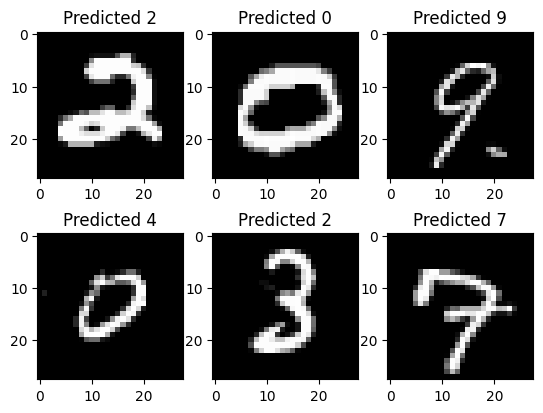

In [83]:
# Plotagem das imagens com rótulos previstos

# Criação da figura e dos eixos
plt.figure()
f, axarr = plt.subplots(2, 3)

# Contador para iterar sobre as imagens
counter = 0

# Iteração para plotar as imagens e rótulos previstos
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")  # Plotagem da imagem
        axarr[i][j].set_title(
            f"Predicted {labels[counter]}"
        )  # Definição do título com o rótulo previsto
        counter += 1  # Atualização do contador para a próxima imagem